In [1]:
import sys
import cPickle as pickle
import gzip
import datetime as dt

import numpy as np
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

sys.path.append("../utils/")
import Strikezone as sz

In [2]:
## Load in pitch data dataframes from pre-saved pickles

fins = [
    "../output_fromJSON/pitches_2014.pkl.gz",
    "../output_fromJSON/pitches_2015.pkl.gz",
    "../output_fromJSON/pitches_2016.pkl.gz",
    "../output_fromJSON/pitches_2017.pkl.gz",
    "../output_fromJSON/pitches_2018.pkl.gz",
    "../output_fromJSON/pitches_2019.pkl.gz",
]
dfs = []
for fin in fins:
    dfs.append(pd.read_pickle(fin, compression="gzip"))
df = pd.concat(dfs, ignore_index=True)

print "shape:", df.shape

shape: (4363258, 66)


In [3]:
# filter out non-called pitches and pitches with no pfx data
df = df.query("px>-900 & (strike_type=='C' | strike_type=='B')")
print "shape:", df.shape

shape: (2306023, 66)


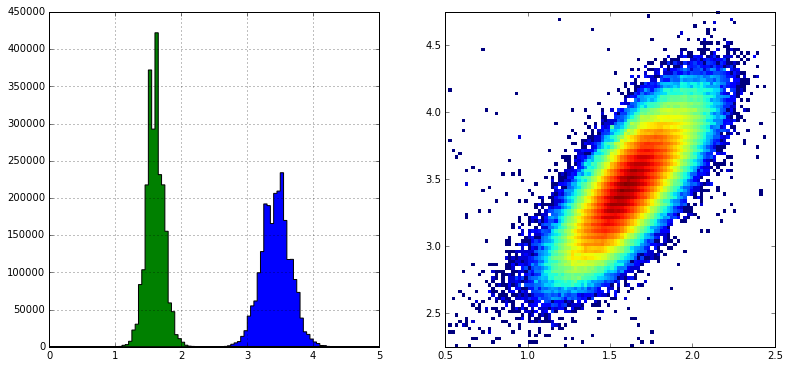

In [4]:
## Investigate the sz_bot and sz_top values.
## Should be fairly narrowly peaked (variation comes from player heights/stances), 
## and directly correlated

plt.figure(figsize=(13,6))
plt.subplot(121)
df.sz_top.hist(bins=np.linspace(0,5,101), histtype='stepfilled')
df.sz_bot.hist(bins=np.linspace(0,5,101), histtype='stepfilled')
plt.subplot(122)
plt.hist2d(df.sz_bot.values, df.sz_top.values, bins=100, range=[[0.5,2.5],[2.25,4.75]], norm=colors.LogNorm());

In [5]:
## compute a normalized pz, accounting for different strikezone edges
## (so 0 < pz_norm < 1 should be the nominal vertical strikezone boundaries)

mean_sztop = df.sz_top.mean()
mean_szbot = df.sz_bot.mean()
df["pz_norm"] = (df.pz-df.sz_bot)/(df.sz_top-df.sz_bot)
print "SZ top:", mean_sztop
print "SZ bot:", mean_szbot
df[["pz","sz_bot","sz_top","pz_norm","strike_type"]].head()

SZ top: 3.43722820282
SZ bot: 1.59874737263


,pz,sz_bot,sz_top,pz_norm,strike_type
621,3.10,1.79,3.84,0.639024,B
622,1.25,1.84,3.81,-0.299492,B
623,1.74,1.78,3.75,-0.020305,C
624,2.40,1.79,3.78,0.306533,C
625,1.48,1.79,3.65,-0.166667,B


In [6]:
szcoll = sz.StrikezoneCollection()
df['year'] = df.date.dt.year
szcoll.add("all_LHH", sz.Strikezone(df, sel="BH=='L'", smooth=3))
szcoll.add("all_RHH", sz.Strikezone(df, sel="BH=='R'", smooth=3))

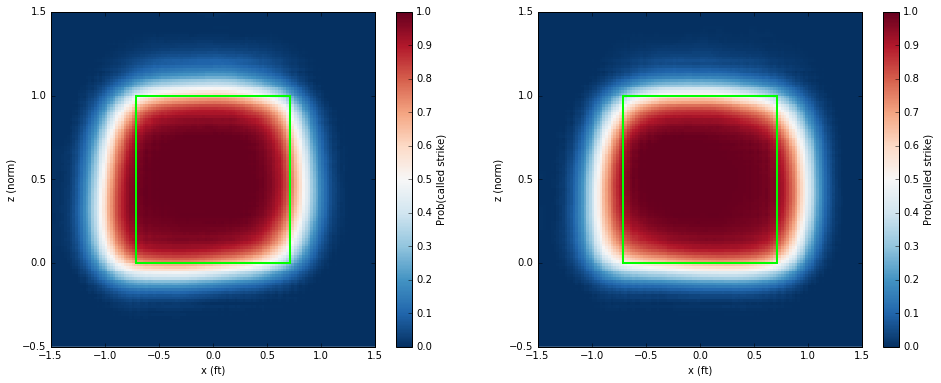

In [7]:
fig = plt.figure(figsize=(16,6))
szcoll.get("all_LHH").plot(ax=fig.add_subplot(121), smoothed=True, sz_zbounds=None)
szcoll.get("all_RHH").plot(ax=fig.add_subplot(122), smoothed=True, sz_zbounds=None)

In [8]:
## get yearly strikezones
for year in range(2014,2020):
    szcoll.add("{0}_LHH".format(year), sz.Strikezone(df, sel="BH=='L' & year=={0}".format(year), smooth=3))
    szcoll.add("{0}_RHH".format(year), sz.Strikezone(df, sel="BH=='R' & year=={0}".format(year), smooth=3))
szcoll.to_pickle("../data/strikezones.pkl")

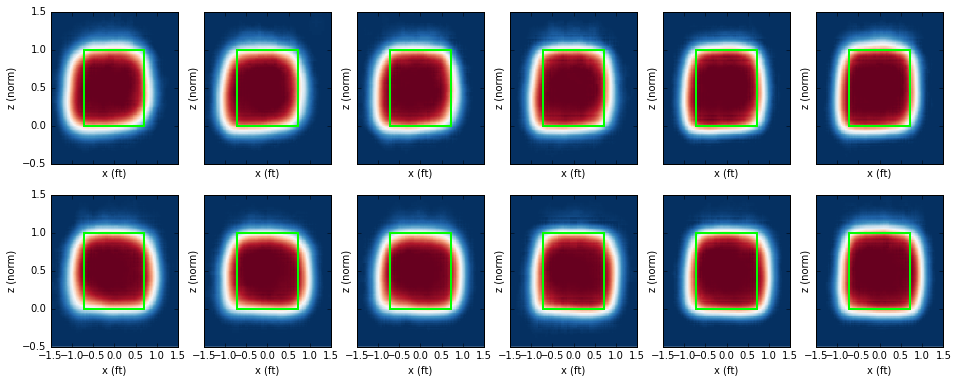

In [9]:
fig = plt.figure(figsize=(16,6))
nyears = 6
ax = {}
for i,year in enumerate(range(2014,2014+nyears)):
    idx = nyears+i+1
    ax[idx] = fig.add_subplot(2,nyears,idx, sharey=ax[nyears+1] if i>0 else None)
    if i>0:
        plt.setp(ax[idx].get_yticklabels(), visible=False)
    szcoll.get("{0}_RHH".format(year)).plot(ax=ax[idx], smoothed=True, sz_zbounds=None, cb=False)
    idx = i+1
    ax[idx] = fig.add_subplot(2,nyears,idx, sharex=ax[nyears+i+1] if i>0 else None, sharey=ax[1] if i>0 else None)
    plt.setp(ax[idx].get_xticklabels(), visible=False)
    if i>0:
        plt.setp(ax[idx].get_yticklabels(), visible=False)
    szcoll.get("{0}_LHH".format(year)).plot(ax=ax[idx], smoothed=True, sz_zbounds=None, cb=False)


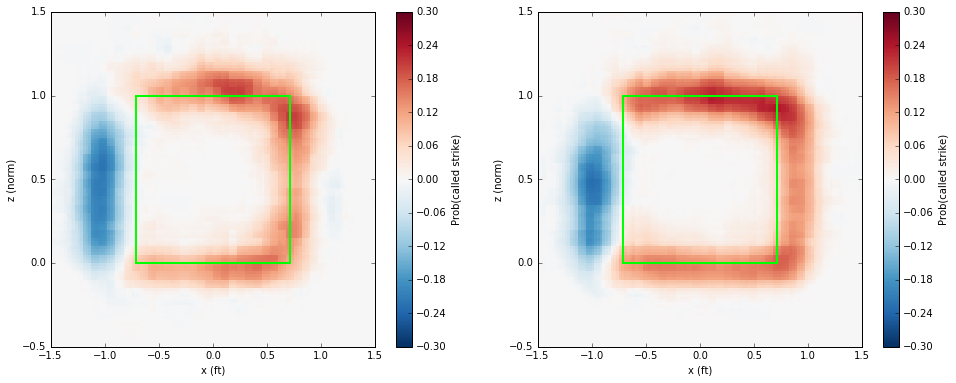

In [10]:
## How has called strikezone changed from 2016 to 2019?
plt.figure(figsize=(16,6))
szcoll.plot_diff("2019_LHH","2016_LHH", ax=plt.subplot(121), smoothed=True, zlim=(-0.3,0.3))
szcoll.plot_diff("2019_RHH","2016_RHH", ax=plt.subplot(122), smoothed=True, zlim=(-0.3,0.3))

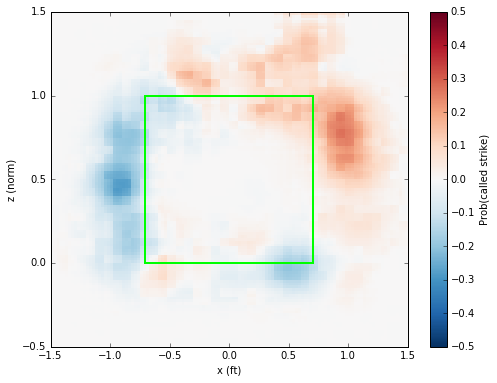

In [11]:
## Look at CB Buckner's called strikezone compared to league average
## Looks like he calls inside strikes against righties less often,
## and upper-half outside strikes more often

cbb = sz.Strikezone(df, sel="umpire==427044 & BH=='R'", smooth=3)
umpcoll = sz.StrikezoneCollection()
umpcoll.add("all_RHH", szcoll.get("all_RHH"))
umpcoll.add("cbbuckner_RHH", cbb)
plt.figure(figsize=(8,6))
umpcoll.plot_diff("cbbuckner_RHH","all_RHH", smoothed=True)